# <font color=red>SMU DS 7331 DATA MINING - MINILAB LOGISTIC REGRESSION AND SVMS</font>

**Team Members:**
- YuMei Bennett
- Liang Huang
- Ganesh Kodi
- Eric McCandless

## <font color=blue>CREATE MODELS (50 POINTS)</font>

**Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe.**

We will use logistic regression to describe data and to explain the relationship between one dependent binary variable (<=50K, >50K income) and several independent variables.  We will also use a support vector machine as a discriminative classifier which is based on a separating hyperplane to categorize new records. 

We will compare the performance of each model.

**Prep data for logistic regression model and support vector machine model:**

In [2]:
# import all necessary modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import Imputer
import seaborn as sns

#Read in dataset.
col_names = ['age', 'employ_type', 'pop_num', 'edu_level', 'edu_years', 'marital', 'occ', 'relation', 'race', 'gender', 'cap_gain', 'cap_loss', 'hours_week', 'country_orig', 'income']
df = pd.read_csv('adult.csv', names=col_names, header=None)

#Replace "?" with "Other_cat"
df['employ_type'] = df['employ_type'].str.replace('?','Other_cat')
df['occ'] = df['occ'].str.replace('?','Other_cat')
df['country_orig'] = df['country_orig'].str.replace('?','Other_cat')

# Binary encoding of the target variable
df['income'] = df['income'].apply(lambda inc: 0 if inc ==" <=50K" else 1) 

#Transform employ_type into multiple columns with 0 and 1
# use pd.concat to join the new columns with original dataframe then drop the original 'employ_type' column (don't need it anymore)
df = pd.concat([df,pd.get_dummies(df['employ_type'], prefix='emp')],axis=1)
df.drop(['employ_type'],axis=1, inplace=True)

#Transform gender into multiple columns with 0 and 1
# use pd.concat to join the new columns with original dataframe then drop the original 'gender' column (don't need it anymore)
df = pd.concat([df,pd.get_dummies(df['gender'], prefix='gen')],axis=1)
df.drop(['gender'],axis=1, inplace=True)

#Transform race into multiple columns with 0 and 1
# use pd.concat to join the new columns with original dataframe then drop the original 'race' column (don't need it anymore)
df = pd.concat([df,pd.get_dummies(df['race'], prefix='rac')],axis=1)
df.drop(['race'],axis=1, inplace=True)

#Transform education_level into multiple columns with 0 and 1
# use pd.concat to join the new columns with original dataframe then drop the original 'edu_level' column (don't need it anymore)
df = pd.concat([df,pd.get_dummies(df['edu_level'], prefix='edu')],axis=1)
df.drop(['edu_level'],axis=1, inplace=True)

#Consolidate education levels because many of them have the similar impact to target income.
df['edu_ SomeCollege'] = df['edu_ Some-college'] + df['edu_ Assoc-acdm'] + df['edu_ Assoc-voc'] 
df['<HS'] = df['edu_ 12th'] + df['edu_ 11th'] + df['edu_ 10th'] + df['edu_ 9th'] + df['edu_ 7th-8th'] + df['edu_ 5th-6th']+ df['edu_ 1st-4th'] + df['edu_ Preschool'] 
df=df.drop(['edu_ Some-college','edu_ Assoc-acdm','edu_ Assoc-voc', 'edu_ 12th', 'edu_ 11th','edu_ 10th','edu_ 9th','edu_ 7th-8th','edu_ 7th-8th','edu_ 5th-6th','edu_ 1st-4th','edu_ Preschool'], 1)

# drop edu_years as it is highly correlated with edu_level.
df=df.drop(['edu_years'], 1)

#Transform relation into multiple columns with 0 and 1
# use pd.concat to join the new columns with original dataframe then drop the original 'relation' column (don't need it anymore)
df = pd.concat([df,pd.get_dummies(df['relation'], prefix='rel')],axis=1)
df.drop(['relation'],axis=1, inplace=True)

#Transform marital into multiple columns with 0 and 1
# use pd.concat to join the new columns with original dataframe then drop the original 'marital' column (don't need it anymore)
df = pd.concat([df,pd.get_dummies(df['marital'], prefix='mar')],axis=1)
df.drop(['marital'],axis=1, inplace=True)

#Consolidate marital status because too many similar categories.  Married-civ-spouse and Married-AF-spouse are similar as are non-married.
df['Married'] = df['mar_ Married-civ-spouse'] + df['mar_ Married-AF-spouse'] 
df['Sep_Div_Absent_Wid'] = df['mar_ Divorced'] + df['mar_ Separated'] + df['mar_ Widowed'] + df['mar_ Married-spouse-absent']
df['Never_Married'] = df['mar_ Never-married']
df=df.drop(['mar_ Married-civ-spouse','mar_ Married-AF-spouse','mar_ Divorced', 'mar_ Separated', 'mar_ Widowed','mar_ Married-spouse-absent','mar_ Never-married'], 1)

#Transform occ into multiple columns with 0 and 1
# use pd.concat to join the new columns with original dataframe then drop the original 'occ' column (don't need it anymore)
df = pd.concat([df,pd.get_dummies(df['occ'], prefix='occu')],axis=1)
df.drop(['occ'],axis=1, inplace=True)

#Consolidate occupation by combining 'Other-service', 'Other_cat', and 'Armed-Forces. 'Other' categories are combined because they are not defined and Armed-Forces has an extremely small number of occurences.
df['occu_ Other'] = df['occu_ Other-service'] + df['occu_ Other_cat'] + df['occu_ Armed-Forces'] 
df=df.drop(['occu_ Other-service','occu_ Other_cat','occu_ Armed-Forces'], 1)

# drop pop_num as population number is an assigned index number, it has no meaning or contribution to our target income.
df=df.drop(['pop_num'], 1)

# Combine all non-U.S. native countries as only ~10% people are not from US - code native country into binary 1=United-States
df['country_orig'] = df['country_orig'].apply(lambda inc: 1 if inc ==" United-States" else 0) 

# merge capital gain and capital losscap_gain and cap_loss as it can be mathmatically concatenated into a single feature cap_gain_loss = cap_gain - cap_loss.
df['cap_gain-loss'] = df['cap_gain'] - df['cap_loss'] 
df=df.drop(['cap_gain','cap_loss'], 1)
df.head(10)

,age,hours_week,country_orig,income,emp_ Federal-gov,emp_ Local-gov,emp_ Never-worked,emp_ Other_cat,emp_ Private,emp_ Self-emp-inc,...,occu_ Handlers-cleaners,occu_ Machine-op-inspct,occu_ Priv-house-serv,occu_ Prof-specialty,occu_ Protective-serv,occu_ Sales,occu_ Tech-support,occu_ Transport-moving,occu_ Other,cap_gain-loss
0,39,40,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2174
1,50,13,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,38,40,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,53,40,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,28,40,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
5,37,40,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,49,16,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
7,52,45,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,31,50,1,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,14084
9,42,40,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,5178


**Set-up 80/20 training/testing to split data:**

In [3]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'income' in df:
    y = df['income'].values # get the labels we want
    del df['income'] # get rid of the class label
    X = df.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


**Run logistic regression:**

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# create a reusable logisitic regression object
# setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

# use the cv_object that we setup before to iterate through the different training and testing sets. 
# Each time we will reuse the logisitic regression object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # create new variables here so that it is more obvious what the code is doing 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
accuracy 0.8476892369107938
confusion matrix
 [[4609  314]
 [ 678  912]]
====Iteration 1  ====
accuracy 0.8430830646399509
confusion matrix
 [[4594  345]
 [ 677  897]]
====Iteration 2  ====
accuracy 0.8472286196837095
confusion matrix
 [[4595  342]
 [ 653  923]]


The logistic regression shows approximately 84% - 85% accuracy for these runs.  The upper left and lower right indicate how many records were classified correctly as <=50K and >50K income.

**Check the weights:**

In [6]:
# iterate over the coefficients
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = df.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

age has weight of 0.025225238476302165
hours_week has weight of 0.027738498028362934
country_orig has weight of 0.2902368498632068
emp_ Federal-gov has weight of 0.3797945268388549
emp_ Local-gov has weight of -0.41113212416106604
emp_ Never-worked has weight of -0.006124048518978927
emp_ Other_cat has weight of -0.1254860402982991
emp_ Private has weight of -0.23558517492215586
emp_ Self-emp-inc has weight of -0.00722899435453913
emp_ Self-emp-not-inc has weight of -0.7651428500045288
emp_ State-gov has weight of -0.5130257971220225
emp_ Without-pay has weight of -0.042725615843415166
gen_ Female has weight of -1.2927309857267628
gen_ Male has weight of -0.43392513265929017
rac_ Amer-Indian-Eskimo has weight of -0.4162771212065825
rac_ Asian-Pac-Islander has weight of -0.300212807992977
rac_ Black has weight of -0.40102178240463365
rac_ Other has weight of -0.4171117912390797
rac_ White has weight of -0.19203261554294734
edu_ Bachelors has weight of -5.323323477297212e-05
edu_ Doctora

These weights are not normalized.  We want to normalize the features based upon the mean and standard deviation of each column.  This will give us true comparative weights.

In [9]:
from sklearn.preprocessing import StandardScaler

# Do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# Use whatever was last stored in the variables:
# X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05) # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

C:\Users\emccandless\AppData\Local\Continuum\anaconda3_1\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\emccandless\AppData\Local\Continuum\anaconda3_1\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\emccandless\AppData\Local\Continuum\anaconda3_1\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


accuracy: 0.8496852448948258
[[4616  365]
 [ 614  918]]
Never_Married has weight of -0.4557339799340289
<HS has weight of -0.4171586163335972
rel_ Own-child has weight of -0.30171538437107115
occu_ Other has weight of -0.285986875403225
Sep_Div_Absent_Wid has weight of -0.20480939856169553
gen_ Female has weight of -0.20167986515127917
occu_ Farming-fishing has weight of -0.17240511094023456
occu_ Priv-house-serv has weight of -0.17134995125985222
edu_ HS-grad has weight of -0.16619214116306658
occu_ Handlers-cleaners has weight of -0.15930311436674735
emp_ Self-emp-not-inc has weight of -0.12379219491795823
rac_ Other has weight of -0.07929237519389792
rel_ Other-relative has weight of -0.07776140765806908
emp_ Without-pay has weight of -0.07479832584317203
occu_ Machine-op-inspct has weight of -0.060201899109161065
rac_ Amer-Indian-Eskimo has weight of -0.05439773513392739
emp_ State-gov has weight of -0.0467970211871726
emp_ Never-worked has weight of -0.0345451696752295
emp_ Local-

**Plot the weights:**

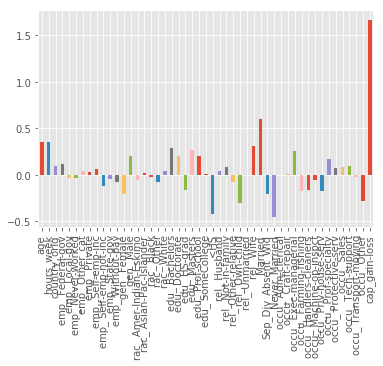

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0],index=df.columns)
weights.plot(kind='bar')
plt.show()

**Run support vector machine model:**

In [11]:
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.8510670965760786
[[4640  341]
 [ 629  903]]


The support vector machine shows approximately 85% accuracy. The upper left and lower right indicate how many records were classified correctly as <=50K and >50K income.

**Look at support vectors:** 

In [13]:
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(9574, 49)
(9574,)
[4982 4592]


In [ ]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
# train the model just as before
svm_clf_lin = SVC(kernel='linear')# Linear Kernel
svm_clf_lin.fit(X_train_scaled, y_train)  # train object

y_hat_lin = svm_clf_lin.predict(X_test_scaled) # get test set precitions

acc_lin = mt.accuracy_score(y_test,y_hat_lin)
conf_lin = mt.confusion_matrix(y_test,y_hat_lin)
print('accuracy:', acc_lin )
print(conf_lin)

## <font color=blue>MODEL ADVANTAGES (10 POINTS)</font>

**Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.**

## <font color=blue>INTERPRET FEATURE IMPORTANCE (30 POINTS)</font>

**Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?**

## <font color=blue>INTERPRET SUPPORT VECTORS (10 POINTS)</font>

**Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.**